In this notebook I am going to separate the articles into multiple chunks and then convert to vectors using encoder models. The vector embeddings of the chunks will be stored in a vector database for fast retrieval during querring.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from tqdm import tqdm
import time
import re
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.tokenize import sent_tokenize
import faiss
import numpy as np
import pickle



Loading the Final_metadata.csv file which contains the titls, url, date of publish and article body

In [2]:
metadata = pd.read_csv("Final_metadata.csv" , index_col = False)

In [3]:
metadata

,title,url,date,text
0,Microfinance in Europe: Survey report 2024,https://social-economy-gateway.ec.europa.eu/mi...,2025-07-14,The European Microfinance Network (EMN) and th...
1,AccessibleEU surpassed all its objectives last...,https://accessible-eu-centre.ec.europa.eu/cont...,2025-07-14,AccessibleEU surpassed all its yearly objectiv...
2,EU invests 2.8 billion in 94 transport project...,https://urban-mobility-observatory.transport.e...,2025-07-11,"On the 3 July 2025, the European Commission an..."
3,Hamburg deploys AI to boost efficiency of elec...,https://urban-mobility-observatory.transport.e...,2025-07-11,"Hadag, the operator of Hamburg’s ferry service..."
4,Israel/Palestine: Statement by the High Repres...,https://north-africa-middle-east-gulf.ec.europ...,2025-07-11,Following the Israeli Cabinet’s resolutions an...
...,...,...,...,...
312,Commission proposes agreements on transfer of ...,https://home-affairs.ec.europa.eu/news/commiss...,2025-06-12,"On 12 June, the European Commission proposed ..."
313,Commission proposes to postpone by one additio...,https://finance.ec.europa.eu/news/commission-p...,2025-06-12,The European Commission has today adopted a de...
314,Commission advances work towards a consolidate...,https://finance.ec.europa.eu/news/commission-a...,2025-06-12,The European Commission has today adopted tech...
315,Education under threat: How EU Trust Fund supp...,https://trust-fund-for-africa.europa.eu/news/e...,2025-06-12,The war in Sudan has devastated the education ...


Let's see the word counts of the text

C:\Users\shri\AppData\Local\Temp\ipykernel_5020\3526067113.py:26: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


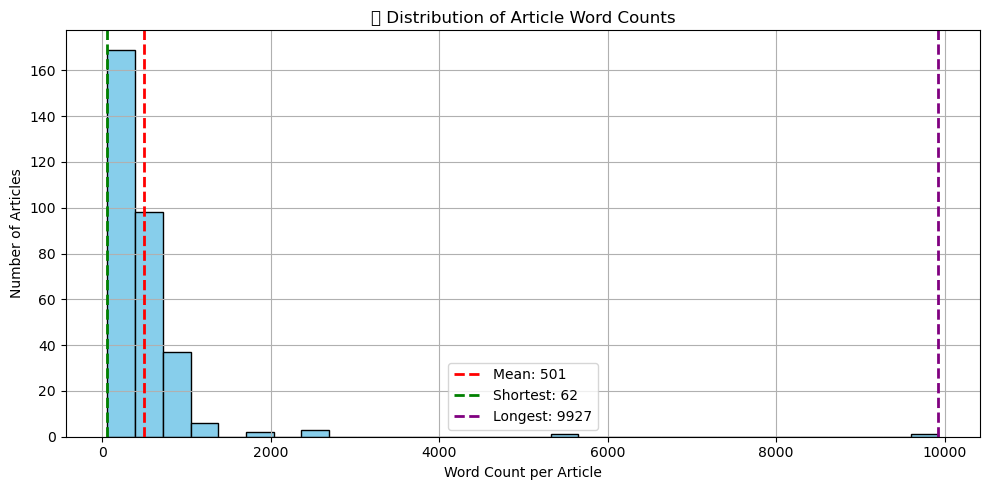

In [4]:
word_counts = []
word_counts = metadata['text'].apply(lambda x: len(str(x).split()))

# mean
mean_words = word_counts.mean()

# shortest and longest article
min_idx = word_counts.idxmin()
max_idx = word_counts.idxmax()

shortest_article = metadata.loc[min_idx]
longest_article = metadata.loc[max_idx]

plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')

plt.axvline(mean_words, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {int(mean_words)}')
plt.axvline(word_counts[min_idx], color='green', linestyle='dashed', linewidth=2, label=f'Shortest: {word_counts[min_idx]}')
plt.axvline(word_counts[max_idx], color='purple', linestyle='dashed', linewidth=2, label=f'Longest: {word_counts[max_idx]}')

plt.xlabel("Word Count per Article")
plt.ylabel("Number of Articles")
plt.title(" Distribution of Article Word Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Let's visit once the longest and smallest text

In [5]:
sorted_indices = word_counts.sort_values().index
smallest_idx = sorted_indices[0] 
largest_idx = sorted_indices[-1] 



In [9]:
print(metadata.loc[smallest_idx]['text'])

European Day of Languages
This year marks the 25th anniversary of the European Day of Languages (EDL). We’re celebrating with a wide variety of language-themed events across Europe in the lead-up to 26 September.Discover what’s happening in a town or city near you!
Ongoing until 16 September:European Day of Languages online national competition 2025(Sweden, country-wide)
8-11 July:TraTra - Translation Summer School(Valletta, Malta)


In [10]:
metadata.loc[smallest_idx]['url']

'https://commission.europa.eu/news-and-media/news/dg-translation-city-near-you-july-events-2025-06-25_en'

In [7]:
print(metadata.loc[largest_idx]['text'])

ent decisions, the European Commission takes legal action against Member States that fail to comply with their obligations under EU law. These decisions, covering various EU policy areas, aim to ensure the proper application of EU law for the benefit of citizens and businesses. The key decisions taken by the Commission are presented below and grouped by policy area. The Commission is also closing 112 cases where the issues with the Member States concerned have been solved. In these cases, the Commission does not have to pursue the infringement procedure further. The Commission's enforcement activities and Member States' compliance with EU law can be followed throughinteractive maps and customisable graphs. For more details on the history of a case or to access the full database of infringement decisions, theinfringement decisions' registeris open for consultation. And more information on the EU infringement procedure can be found in the followingQ&A. (For more information: Maciej Beres

Everything seems alright, let's move towards chunking and vectorisation

## Chunking

Let's once look at the boxplot of the word count of the articles body. Which will help us in deciding the max chunk length. 

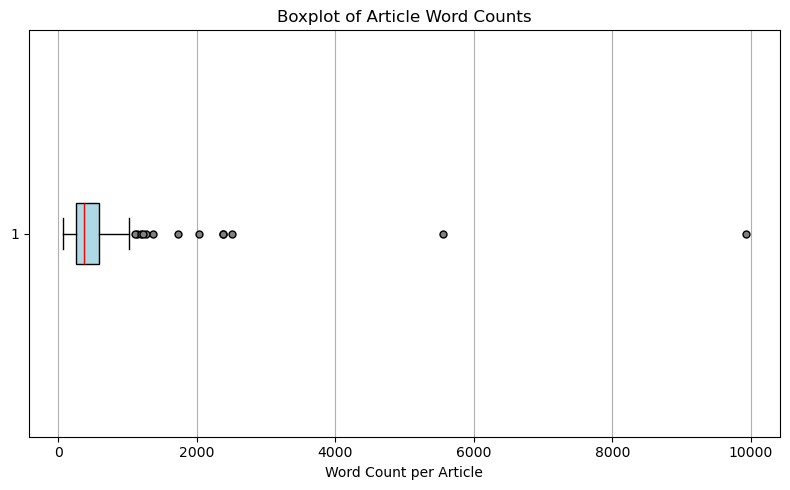

In [8]:
plt.figure(figsize=(8, 5))
plt.boxplot(word_counts, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red'),
            flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none'))

plt.xlabel("Word Count per Article")
plt.title("Boxplot of Article Word Counts")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [9]:
max_length = word_counts.max()


At this step we need to break the articles in such a way that there is no loss of the information in this process. As we saw there were many articles which contained tables and we scraped them as it is. If by any means the chunks separates a tble then the resultant set is not meaningful.

As the mean size of our articles is 501. Let's see how many of the articles fall in mean, max length category

In [21]:
long_articles = word_counts[(word_counts > mean_words) & (word_counts <= max_length)]


In [22]:
len(long_articles)

104

In [23]:
len(word_counts)

317

Lets's analyse one scraped text which contains a table. Let's see its syntactical structure and see what effect different chunck length has on it


In [24]:
metadata[metadata['url'] == 'https://commission.europa.eu/news-and-media/news/results-02-07-2025-auction-eu-bills-2025-07-02_en']


,title,url,date,text
101,Results of 02-07-2025 auction (EU-Bills),https://commission.europa.eu/news-and-media/ne...,2025-07-02,"The European Commission, on behalf of the Euro..."


In [25]:
metadata.loc[101]['text']

'The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction. The results of this auction are as follows:\nEU-Bills\nEU-Bills\nEU-Bills\nISIN\nEU000A4D85M6\nEU000A3L7AT2\nEU000A4EDCQ2\nDate of auction\n02/07/2025\n02/07/2025\n02/07/2025\nSettlement date\n04/07/2025\n04/07/2025\n04/07/2025\nMaturity\n03/10/2025\n09/01/2026\n03/07/2026\nVolume bids *\n1466\n2594\n4079\nVolume allotment *\n841\n997\n1398\nOld outstanding amount *\n2290\n2399\n0\nNew outstanding amount *\n3131\n3396\n1398\nWeighted average yield\n1.922%\n1.930%\n1.920%\nHighest accepted yield\n1.935%\n1.940%\n1.935%\n% awarded at highest accepted yield\n100%\n100%\n51.85%\nCover ratio\n1.74\n2.60\n2.92\n* in millions of euros'

Let's see which pages has tables in it

In [27]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)


In [28]:
indices_with_tables = []

for i in tqdm(range(len(metadata))): 
    url = metadata.loc[i, 'url']
    try:
        driver.get(url)
        time.sleep(2.5)  # wait for JS to render

        soup = BeautifulSoup(driver.page_source, "html.parser")

        if soup.find("table"):
            indices_with_tables.append(i)

    except Exception as e:
        print(f"Error at index {i} ({url}): {e}")

driver.quit()

print(f"Found tables in {len(indices_with_tables)} pages.")
print("Sample indices:", indices_with_tables[:10])

100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [17:35<00:00,  3.33s/it]


Found tables in 8 pages.
Sample indices: [11, 44, 101, 147, 203, 237, 238, 285]


In [62]:
metadata.loc[147,'url']

'https://commission.europa.eu/news-and-media/news/announcement-next-auction-eu-bills-02-07-2025-2025-06-27_en'

Detecting lists

In [36]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

driver = webdriver.Chrome(options=options)

indices_with_lists = []

for i in tqdm(range(len(metadata)), desc="Checking for lists"):
    url = metadata.loc[i, 'url']
    try:
        driver.get(url)
        time.sleep(2.5)  # Wait for JS to render

        soup = BeautifulSoup(driver.page_source, "html.parser")

        # Checking if page has at least one <ul> or <ol>
        if soup.find("ul") or soup.find("ol"):
            indices_with_lists.append(i)

    except Exception as e:
        print(f" Error at index {i} ({url}): {e}")

driver.quit()

print(f"Found lists in {len(indices_with_lists)} pages.")
print("Sample indices:", indices_with_lists[:10])


Checking for lists: 100%|████████████████████████████████████████████████████████████| 317/317 [17:02<00:00,  3.23s/it]


Found lists in 316 pages.
Sample indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [37]:
metadata.loc[0,'url']

'https://social-economy-gateway.ec.europa.eu/microfinance-europe-survey-report-2024-2025-07-14_en'

leave list lets re scrap just table pages with "<table /table> tags,such that later I could perform the chunking with no data loss.

In [63]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)

# Scraping pages from URLs that contain tables
for i in tqdm(indices_with_tables, desc="Scraping tables from .ecl-table tags"):
    url = metadata.loc[i, 'url']
    try:
        driver.get(url)
        time.sleep(3) 

        soup = BeautifulSoup(driver.page_source, "html.parser")

        # Find all tables with class "ecl-table"
        tables = soup.find_all("table", class_="ecl-table")
        structured_tables = []

        for table in tables:
            rows = table.find_all("tr")
            table_data = []
            for row in rows:
                cols = row.find_all(['td', 'th'])
                table_data.append([col.get_text(strip=True) for col in cols])
            table_str = "<table>\n" + "\n".join(["\t".join(row) for row in table_data]) + "\n</table>"
            structured_tables.append(table_str)

        # Combining all tables into final text
        full_text = "\n\n".join(structured_tables)
        table_tagged_texts[i] = full_text

    except Exception as e:
        print(f" Error at index {i} ({url}): {e}")
        table_tagged_texts[i] = ""

driver.quit()

Scraping tables from .ecl-table tags: 100%|██████████████████████████████████████████████| 8/8 [00:30<00:00,  3.76s/it]


In [81]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)

table_tagged_texts = {}

for i in tqdm(indices_with_tables, desc="Scraping full ecl content"):
    url = metadata.loc[i, 'url']
    try:
        driver.get(url)
        time.sleep(3)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        ecl_div = soup.find("div", class_="ecl")
        if not ecl_div:
            print(f"❌ No .ecl div found at index {i}")
            table_tagged_texts.append("")
            continue

        full_text = ""

        for el in ecl_div.descendants:
            if el.name in ['p', 'li', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
                full_text += el.get_text(strip=True) + "\n"

            elif el.name == "table" and "ecl-table" in el.get("class", []):
                rows = el.find_all("tr")
                table_data = []
                for row in rows:
                    cols = row.find_all(['td', 'th'])
                    table_data.append([col.get_text(strip=True) for col in cols])
                if table_data:
                    table_str = "<table>\n" + "\n".join(["\t".join(row) for row in table_data]) + "\n</table>"
                    full_text += table_str + "\n"

        table_tagged_texts[i] = full_text.strip()

    except Exception as e:
        print(f" Error at index {i} ({url}): {e}")
        table_tagged_texts.append("")

driver.quit()

Scraping full ecl content: 100%|█████████████████████████████████████████████████████████| 8/8 [00:30<00:00,  3.85s/it]


In [82]:
table_tagged_texts

{11: 'Today, the European Commission announced that it will, on behalf of the European Union, auction the following securities:\n<table>\n\tEU-Bills\tEU-Bills\tEU-Bills\nISIN\tEU000A4D85M6\tEU000A3L7AT2\tEU000A4EDCQ2\nDate of auction\t16/07/2025\t16/07/2025\t16/07/2025\nSettlement date\t18/07/2025\t18/07/2025\t18/07/2025\nMaturity\t03/10/2025\t09/01/2026\t03/07/2026\nAnnounced volume *\tup to 1000\tup to 1000\tup to 1000\n</table>\n* in millions of euros\nMembers of the EU Primary Dealer Network are entitled to bid.Primary Dealers who wish to participate to the auction should be connected to TELSAT at 09:45\xa0a.m.\xa0CET on the date of the auction.Bidding closes at 12:00\xa0p.m.\xa0CET on the date of the auction.',
 44: 'Today, the European Commission announced that it will, on behalf of the European Union, auction the following securities:\n<table>\n\tEU-Bonds04/07/20282.625%\tEU-Bonds04/07/20343.250%\tEU-Bonds05/10/20543.375%\nISIN\tEU000A4D5QM6\tEU000A3K4D41\tEU000A3K4EY2\nDate of 

In [83]:
text = table_tagged_texts[44] 

# Find all content between <table> and </table>
tables_extracted = re.findall(r'<table>(.*?)</table>', text, re.DOTALL)

# Display how many tables were found and preview one
print(f"Found {len(tables_extracted)} table(s).")
for i, t in enumerate(tables_extracted):
    print(f"\n--- Table {i+1} ---\n{t.strip()[:500]}")

Found 1 table(s).

--- Table 1 ---
EU-Bonds04/07/20282.625%	EU-Bonds04/07/20343.250%	EU-Bonds05/10/20543.375%
ISIN	EU000A4D5QM6	EU000A3K4D41	EU000A3K4EY2
Date of auction	14/07/2025	14/07/2025	14/07/2025
Settlement date	16/07/2025	16/07/2025	16/07/2025
Maturity	04/07/2028	04/07/2034	05/10/2054
Announced volume *	up to 2000	up to 2000	up to 1000


Now it seems correct. I will replace the content of these indices in the metadata with these. then we will decide about chunking and vectorisation.

In [84]:
table_tagged_texts[44]

'Today, the European Commission announced that it will, on behalf of the European Union, auction the following securities:\n<table>\n\tEU-Bonds04/07/20282.625%\tEU-Bonds04/07/20343.250%\tEU-Bonds05/10/20543.375%\nISIN\tEU000A4D5QM6\tEU000A3K4D41\tEU000A3K4EY2\nDate of auction\t14/07/2025\t14/07/2025\t14/07/2025\nSettlement date\t16/07/2025\t16/07/2025\t16/07/2025\nMaturity\t04/07/2028\t04/07/2034\t05/10/2054\nAnnounced volume *\tup to 2000\tup to 2000\tup to 1000\n</table>\n* in millions of euros\n\nMembers of the EU Primary Dealer Network are entitled to bid.Primary Dealers who wish to participate to the auction should be connected to TELSAT at 09:15\xa0a.m.\xa0CET on the date of the auction.Bidding closes at 11:30\xa0p.m.\xa0CET on the date of the auction.'

Now that I have extracted the table pages with table tags lets replace the text in the metadata dataframe.

In [141]:
# metadata.loc[10]['text']

In [87]:
for idx, new_text in table_tagged_texts.items():
    metadata.at[idx, 'text'] = new_text

In [88]:
metadata.to_csv("Final_metadata_table_tags.csv" , index = False)

In [230]:
# metadata = pd.read_csv("Final_metadata_table_tags.csv"  , index_col = False)

In [208]:
import pickle
from nltk.tokenize.punkt import PunktSentenceTokenizer

punkt_path = r"C:\Users\shri\Data_Science\Text Mining\nltk\tokenizers\punkt\english.pickle"
with open(punkt_path, "rb") as f:
    tokenizer = pickle.load(f)

#  Override NLTK's sent_tokenize
sent_tokenize = tokenizer.tokenize

Let's perform the semantic chunking of the article text. 

In [12]:
def safe_append_chunk(chunks, current_chunk, max_words):
    words = " ".join(current_chunk).split()
    if len(words) <= max_words:
        chunks.append(" ".join(current_chunk))
    else:
        for i in range(0, len(words), max_words):
            chunks.append(" ".join(words[i:i+max_words]))


def semantic_chunking(text, model, max_words, similarity_threshold):
    sentences = sent_tokenize(text)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    chunks = []
    current_chunk = []
    i = 0

    while i < len(sentences):
        current_chunk.append(sentences[i])
        current_length = len(" ".join(current_chunk).split())

        if current_length > max_words:
            # Pop last sentence and append safe
            last_sentence = current_chunk.pop()
            safe_append_chunk(chunks, current_chunk, max_words)
            current_chunk = [last_sentence]
            i += 1
            continue

        if i + 1 < len(sentences):
            emb1 = model.encode(sentences[i], convert_to_tensor=True)
            emb2 = model.encode(sentences[i + 1], convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()

            if sim < similarity_threshold:
                safe_append_chunk(chunks, current_chunk, max_words)
                current_chunk = []

        i += 1

    # Final leftover
    if current_chunk:
        safe_append_chunk(chunks, current_chunk, max_words)

    return chunks


In [177]:
all_chunks = []
chunk_index_map = {}

model = SentenceTransformer('all-MiniLM-L6-v2')

for idx, text in tqdm(metadata['text'].items()):
    chunks = semantic_chunking(text = text , model = model , max_words = 300, similarity_threshold=0.75)
    
    # Store mapping from current index to chunk indices
    start = len(all_chunks)
    all_chunks.extend(chunks)
    end = len(all_chunks)
    
    chunk_index_map[idx] = list(range(start, end))

317it [03:38,  1.45it/s]


In [178]:
len(all_chunks)

6124

In [262]:
chunk_index_map[203]

[3699, 3700]

In [263]:
all_chunks[3699]

'The European Commission, on behalf of the European Union, has today carried out an EU-Bonds auction.'

In [264]:
all_chunks[3700]

'The results of this auction are as follows:\n<table>\n\tEU-Bonds05/10/20292.875%\tEU-Bonds12/12/20353.375%\tEU-Bonds06/07/20510.700%\nISIN\tEU000A3L1CN4\tEU000A4D8KD2\tEU000A3KTGW6\nDate of auction\t23/06/2025\t23/06/2025\t23/06/2025\nSettlement date\t25/06/2025\t25/06/2025\t25/06/2025\nMaturity\t05/10/2029\t12/12/2035\t06/07/2051\nVolume bids *\t2 810\t2 788\t1 467\nVolume allotment *\t1 798\t2 182\t1 372\nOld outstanding amount *\t14 510\t9 000\t14 000\nNew outstanding amount *\t16 308\t11 182\t15 372\nWeighted average price\t101.973%\t102.462%\t51.174%\nLowest accepted price\t101.960%\t102.420%\t51.100%\n% awarded at lowest accepted price\t100.00%\t100.00%\t100.00%\nWeighted average yield\t2.383%\t3.096%\t3.631%\nCover ratio\t1.56\t1.28\t1.07\n</table>\n* in millions of euros'

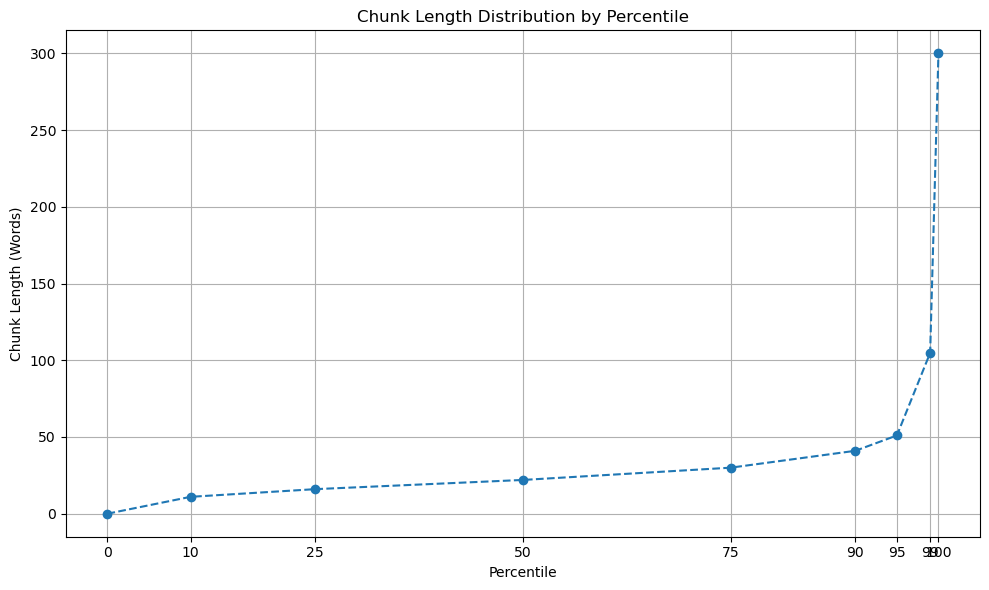

In [266]:
chunk_lengths = [len(chunk.split()) for chunk in all_chunks]

percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
percentile_values = np.percentile(chunk_lengths, percentiles)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, percentile_values, marker='o', linestyle='--')
plt.title('Chunk Length Distribution by Percentile')
plt.xlabel('Percentile')
plt.ylabel('Chunk Length (Words)')
plt.grid(True)
plt.xticks(percentiles)
plt.tight_layout()
plt.show()

In [267]:
np.percentile(chunk_lengths, 99)

104.76999999999953

In [179]:
print(all_chunks[:10])

['The European Microfinance Network (EMN) and the Microfinance Centre (MFC) are pleased to present the12th editionof their flagship publication:Microfinance in Europe: Survey Report.', 'This long-standing survey remains the leading source of data and analysis on the microfinance sector in Europe.', 'For thesixth consecutive survey edition, EMN and MFC have joined forces to capture data from the vast majority of European microfinance institutions, providing the most comprehensivedatasetavailable on the sector today.', 'This edition focuses on thetypes of businesses reached by microfinanceand highlights thesocial performance of business loans, along with theimpact measurement approachesadopted by MFIs.', 'It offers valuable insights into how these institutions contribute to social inclusion, entrepreneurship, and local development.', 'The report serves as an importantpolicy tool, supportingevidence-based decision-making for policymakersworking to strengthen financial inclusion and the so

In [185]:
with open("semantic_chunks_2.pkl", "wb") as f:
    pickle.dump({"chunks": all_chunks, "index_map": chunk_index_map}, f)

In [186]:
# chunk_index_map

Now the whole text has been splitted into chunks. Let's move to the next step.

In [180]:

min_idx = min(range(len(all_chunks)), key=lambda i: len(all_chunks[i].split()))
max_idx = max(range(len(all_chunks)), key=lambda i: len(all_chunks[i].split()))

shortest_chunk = all_chunks[min_idx]
longest_chunk = all_chunks[max_idx]

print(f"🔹 Shortest chunk (index {min_idx}, {len(shortest_chunk.split())} words):\n{shortest_chunk}\n")
print("="*80)
print(f"🔸 Longest chunk (index {max_idx}, {len(longest_chunk.split())} words):\n{longest_chunk}")



🔹 Shortest chunk (index 1820, 0 words):


🔸 Longest chunk (index 1821, 300 words):
ataDatabaseStatistical themesStats finder A-ZExperimental statisticsData visualisationsEducation cornerAdvanced tools and servicesWeb servicesBulk downloadGISCO:Geographical Information and mapsMicrodataQuality and European statisticsQualityMetadataData validationData revision policySDMX InfoSpaceResearch and methodology (CROS)Evaluations Explore dataDatabaseStatistical themesStats finder A-ZExperimental statisticsData visualisationsEducation corner Explore data Database Statistical themes Stats finder A-Z Experimental statistics Data visualisations Education corner Advanced tools and servicesWeb servicesBulk downloadGISCO:Geographical Information and mapsMicrodata Advanced tools and services Web services Bulk download GISCO:Geographical Information and maps Microdata Quality and European statisticsQualityMetadataData validationData revision policySDMX InfoSpaceResearch and methodology (CROS)Evaluations 

In [183]:
short_chunks = [chunk for chunk in all_chunks if len(chunk.split()) < 5]
print(f"Number of chunks shorter than 5 words: {len(short_chunks)}")


Number of chunks shorter than 5 words: 102


In [184]:
for i, chunk in enumerate(short_chunks[:20]):
    print(f"{i+1:02d}. ({len(chunk.split())} words): {chunk}")


01. (3 words): EU-China energy cooperation
02. (4 words): At home in Europe.
03. (4 words): Building hope and opportunity.
04. (4 words): To my second point.
05. (4 words): Finally, on political support.
06. (2 words): Slava Ukraini.
07. (3 words): Long live Europe.
08. (4 words): Joint Assessment Framework dashboard
09. (1 words): 2.
10. (3 words): And cold weather?
11. (1 words): 3.
12. (4 words): It’s not just storms.
13. (1 words): 4.
14. (1 words): 5.
15. (3 words): The good news?
16. (4 words): We are not powerless.
17. (4 words): How does it work?
18. (3 words): 9 JULY 2025
19. (4 words): More information and application
20. (1 words): 2.


We can see that there are a numerical indexes in the chunks. I am going to remove them in the next step

In [29]:
def is_useful_short_chunk(chunk):
    words = chunk.split()
    text = chunk.strip().lower()

    # Heuristics to discard:
    if len(words) <= 2 and text.strip("0123456789. ") == "":
        return False  # pure enumeration like "2.", "3"
    if len(text) == 0:
        return False  # empty
    if text in {"yes", "no", "okay", "thanks"}:
        return False  # too generic
    
    return True

filtered_chunks = [
    chunk for chunk in all_chunks
    if len(chunk.split()) >= 5 or is_useful_short_chunk(chunk)
]


In [188]:
print(f"Filtered chunks: {len(filtered_chunks)} / {len(all_chunks)}")


Filtered chunks: 6108 / 6124


In [190]:
short_chunks = [chunk for chunk in filtered_chunks if len(chunk.split()) < 5]
print(f"Number of chunks shorter than 5 words: {len(short_chunks)}")


Number of chunks shorter than 5 words: 86


In [191]:
for i, chunk in enumerate(short_chunks[:20]):
    print(f"{i+1:02d}. ({len(chunk.split())} words): {chunk}")


01. (3 words): EU-China energy cooperation
02. (4 words): At home in Europe.
03. (4 words): Building hope and opportunity.
04. (4 words): To my second point.
05. (4 words): Finally, on political support.
06. (2 words): Slava Ukraini.
07. (3 words): Long live Europe.
08. (4 words): Joint Assessment Framework dashboard
09. (3 words): And cold weather?
10. (4 words): It’s not just storms.
11. (3 words): The good news?
12. (4 words): We are not powerless.
13. (4 words): How does it work?
14. (3 words): 9 JULY 2025
15. (4 words): More information and application
16. (3 words): And cold weather?
17. (4 words): It’s not just storms.
18. (3 words): The good news?
19. (4 words): We are not powerless.
20. (3 words): during chemical recycling.


Now it seems clean

In [192]:
with open("filtered_chunks.txt", "w", encoding="utf-8") as f:
    for chunk in filtered_chunks:
        f.write(chunk.strip() + "\n")


In [193]:
# with open("filtered_chunks.json", "r", encoding="utf-8") as f:
#     filtered_chunks = json.load(f)


Now let's extract the embeddings from the chunks

In [194]:
chunk_embeddings = model.encode(filtered_chunks, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [224]:
embeddings_np.shape[1]

384

In [196]:
# Convert tensor to numpy array
embeddings_np = chunk_embeddings.cpu().detach().numpy()

# Define dimension
embedding_dim = embeddings_np.shape[1]

# Build FAISS index
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings_np)

# Save FAISS index
faiss.write_index(index, "chunk_index.faiss")

In [205]:
query = "List the ISINs of all the EU-Bills discussed."
query_embedding = model.encode([query])

D, I = index.search(np.array(query_embedding).astype("float32"), k=20)

# Show top 5 retrieved chunks
for i in I[0]:
    print(f"- {filtered_chunks[i]}")


- This is illustrated by thedeclaration of the European Union and its Member States.
- Member States and the European Parliament will be informed about the details of the agreement in the coming days.
- The resulting report shall be presented to the European Parliament, the Council and the European Economic and Social Committee.
- It went through the comitology procedure and therefore has theblessing of the 27 EU Member States.
- As from 2023, thanks to cooperation with Member States and Eurocontrol, the detailed data will be published in full.
- With that in mind, theCommission adopted five initiativesto strengthen the EU’s economic security on 24 January 2024 – including the legislative proposal subject to this trilogue.
- The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction.
- The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction.
- The latter will now be transmitted to the European Parliame

From the above example we can see that the retrieved chunks seems non relevant to the question asked. This will lead the LLM to falsy answer generation

In [209]:
semantic_chunking(table_tagged_texts[44])

['Today, the European Commission announced that it will, on behalf of the European Union, auction the following securities:\n<table>\n\tEU-Bonds04/07/20282.625%\tEU-Bonds04/07/20343.250%\tEU-Bonds05/10/20543.375%\nISIN\tEU000A4D5QM6\tEU000A3K4D41\tEU000A3K4EY2\nDate of auction\t14/07/2025\t14/07/2025\t14/07/2025\nSettlement date\t16/07/2025\t16/07/2025\t16/07/2025\nMaturity\t04/07/2028\t04/07/2034\t05/10/2054\nAnnounced volume *\tup to 2000\tup to 2000\tup to 1000\n</table>\n* in millions of euros\n\nMembers of the EU Primary Dealer Network are entitled to bid.Primary Dealers who wish to participate to the auction should be connected to TELSAT at 09:15\xa0a.m.\xa0CET on the date of the auction.Bidding closes at 11:30\xa0p.m.\xa0CET on the date of the auction.']

In [210]:
emb1 = model.encode(semantic_chunking(table_tagged_texts[44]), convert_to_tensor=True)
emb2 = model.encode("List the ISINs of all the EU-Bills discussed.", convert_to_tensor=True)
sim = util.cos_sim(emb1, emb2).item()


In [211]:
sim

0.38601166009902954

In [212]:
query = "List the ISINs of all the EU-Bills discussed."
query_embedding = model.encode([query])

D, I = index.search(np.array(query_embedding).astype("float32"), k=5)

#  Compute cosine similarity for each retrieved chunk
print(f"\n🔍 Top {len(I[0])} matched chunks and their similarity scores:")
for idx in I[0]:
    chunk = all_chunks[idx]
    chunk_embedding = model.encode(chunk, convert_to_tensor=True)
    similarity = util.cos_sim(query_embedding, chunk_embedding).item()
    
    print(f"\n📄 Chunk:\n{chunk[:300]}...")  # truncate long chunk
    print(f"🧮 Similarity: {similarity:.4f}")


🔍 Top 5 matched chunks and their similarity scores:

📄 Chunk:
We exchanged experiences regarding sustainable practices in agriculture that are vital for improving climate resilience and soil health, highlighting the value of research and innovation as well as that of agroecological practices and living labs to facilitate sustainable and resilient agriculture....
🧮 Similarity: -0.1082

📄 Chunk:
Ukraine is expected to report every year on its progress in that regard....
🧮 Similarity: 0.2374

📄 Chunk:
Once OLAF has completed its investigation, it is for the competent EU and national authorities to examine and decide on the follow-up of OLAF’s recommendations....
🧮 Similarity: 0.2673

📄 Chunk:
The course has an estimated dedication time of 25 hours and it is imparted in English....
🧮 Similarity: 0.0522

📄 Chunk:
It also delivers national soil festivals, awards and certifications, and aims to expand its impact to 30 regions by 2028....
🧮 Similarity: 0.1351


In [213]:
# Normalizing the embeddings (e.g. shape: [num_chunks, embedding_dim])
embeddings_np = embeddings_np / np.linalg.norm(embeddings_np, axis=1, keepdims=True)

# Use inner product index (acts like cosine similarity if vectors are normalized)
index_cosine = faiss.IndexFlatIP(embeddings_np.shape[1])
index_cosine.add(embeddings_np)

faiss.write_index(index, "chunk_index_cosine.faiss")

In [218]:
query_embedding = model.encode(["When is the deadline for submitting applications to join the Platform on Sustainable Finance?"])[0]
query_embedding = query_embedding / np.linalg.norm(query_embedding)

# Search with cosine similarity
D, I = index_cosine.search(np.array([query_embedding]).astype("float32"), k=5)


In [220]:
for i, idx in enumerate(I[0]):
    print(f"\nChunk {i+1}: {all_chunks[idx]}...")
    print(f"🧠 Cosine Similarity: {D[0][i]:.4f}")



Chunk 1: The new platform will be composed of up to 35 members, of which up to 28 will be selected through today's call for applications....
🧠 Cosine Similarity: 0.7090

Chunk 2: Four pilot projects were implemented in Belgium, Finland, Italy, and the Netherlands, providing tailored support such as training, mentoring, and microloans to over 3,000 migrants....
🧠 Cosine Similarity: 0.6016

Chunk 3: TheRoadmapaims to developclear standards and reliable certification for these nature-positive actionsto make nature credits effective and trustworthy, while avoiding administrative burden when joining such a scheme....
🧠 Cosine Similarity: 0.5568

Chunk 4: InApril 2025, the Commission proposed to amend the EGF regulation to support workers at risk of imminent job loss, allowing earlier intervention by swiftly mobilising support before job losses occur....
🧠 Cosine Similarity: 0.5488

Chunk 5: The European Commission has today launched acall for applicationsfor members of the thirdPlatform on

* Above one was my first attempt with max chunk length 300, embedding model 'all-MiniLM-L6-v2' sentance transformer and euclidean distance as similarity measure.
* Let's try with increasing the length of the chunks to 500 max and then using another encoder based model for deriving vector from the chunks and then using cosine similarity for comparison.

## Let' try 'all-mpnet-base-v2' model which outputs a vector of dimention 768

In [10]:

model_2 = SentenceTransformer('all-mpnet-base-v2')
import torch
if torch.cuda.is_available():
    model_2 = model_2.to('cuda')
    print(" Model loaded to GPU.")
else:
    print( GPU not available, using CPU.")

⚠️ GPU not available, using CPU.


In [13]:
all_chunks_2 = []
chunk_index_map_2 = {}


for idx, text in tqdm(metadata['text'].items()):
    chunks = semantic_chunking(text = text , model = model_2 , max_words = 500,similarity_threshold = 0.50)
    start = len(all_chunks_2)
    all_chunks_2.extend(chunks)
    end = len(all_chunks_2)
    
    chunk_index_map_2[idx] = list(range(start, end))

317it [18:55,  3.58s/it]


In [21]:
with open("semantic_chunks_v2_50.pkl", "wb") as f:
    pickle.dump({"chunks": all_chunks_2, "index_map": chunk_index_map_2}, f)

## the 75 percent similarity chunking merge has been saved with the name of "semantic_chunks_v2.pkl" if you need this load this chunking.

In [34]:
with open("semantic_chunks_v2_50.pkl", "rb") as f:
    pkl = pickle.load(f)
    all_chunks_2 = pkl["chunks"]
    chunk_index_map_2 = pkl["index_map"]



In [35]:
all_chunks_2[156]

'Webpage on EU support for Ukraine\nFactsheet on EU solidarity with Ukraine\nWebpage on Ukraine Investment Framework\nFactsheet on the European Flagship Fund for the reconstruction of Ukraine\nFactsheet on the Ukraine Investment Framework\nToday, the EU reaffirms its role as Ukraine’s strongest partner.'

In [36]:
min_idx = min(range(len(all_chunks_2)), key=lambda i: len(all_chunks_2[i].split()))
max_idx = max(range(len(all_chunks_2)), key=lambda i: len(all_chunks_2[i].split()))

shortest_chunk = all_chunks_2[min_idx]
longest_chunk = all_chunks_2[max_idx]

print(f"🔹 Shortest chunk (index {min_idx}, {len(shortest_chunk.split())} words):\n{shortest_chunk}\n")
print("="*80)
print(f"🔸 Longest chunk (index {max_idx}, {len(longest_chunk.split())} words):\n{longest_chunk}")



🔹 Shortest chunk (index 2465, 0 words):


🔸 Longest chunk (index 2466, 500 words):
Who we are Overview EIB at a glance Overview Tackling global challenges together Partners Part of the EU family Our priorities Our results Overview EIB Group impact: Boosting GDP and jobs EIB Group and the Sustainable Development Goals Governance and structure Overview Shareholders Statutory bodies Control and evaluation Organisation structure Corporate responsibility Overview Providing finance Borrowing Human rights and the EIB Reporting on sustainability Our internal commitment Managing our environment Transparency, accountability and access to information Overview Transparency and access to information EIB Group Complaints Mechanism overview Project procurement complaints Investigating fraud and misconduct Evaluation Public consultations European Investment Fund EIB Institute What we offer Overview Loans Overview Loans for the public sector Framework loans for the public sector Loans for the private s

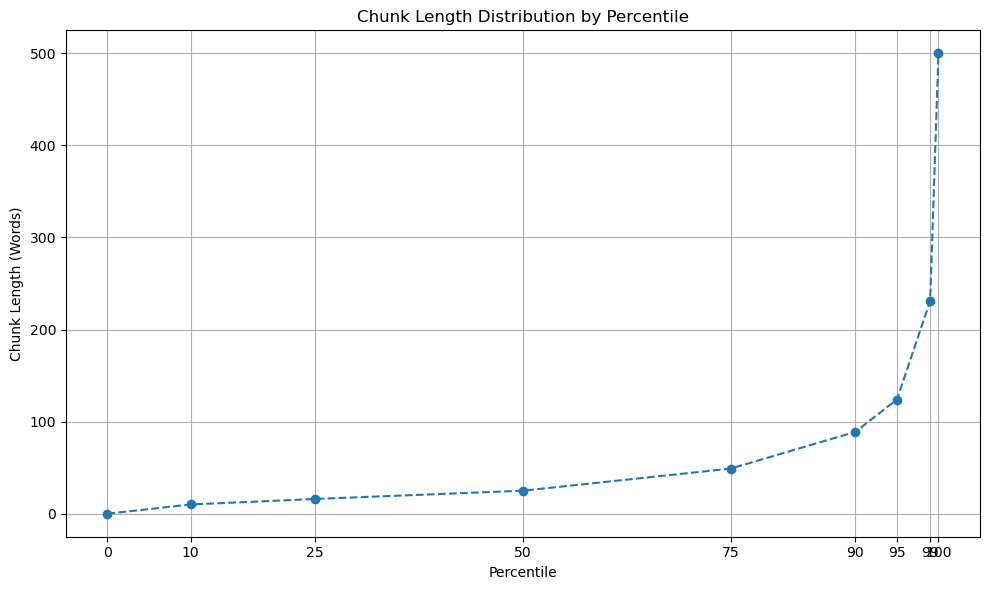

In [37]:
# Step 1: Get lengths (in words) of each chunk
chunk_lengths = [len(chunk.split()) for chunk in all_chunks_2]

# Step 2: Define percentiles you want to see
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
percentile_values = np.percentile(chunk_lengths, percentiles)

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.plot(percentiles, percentile_values, marker='o', linestyle='--')
plt.title('Chunk Length Distribution by Percentile')
plt.xlabel('Percentile')
plt.ylabel('Chunk Length (Words)')
plt.grid(True)
plt.xticks(percentiles)
plt.tight_layout()
plt.show()

Let's do one thing more. 99 percent of the chunks have length less than 104. I think we should decrese the similarity limit from 75 percent to 50. Because we are not able to take advantage of this. WHat is the purpose of using 500 max word count if 99 percent of the chunks are 5 times shorter than it

In [38]:
short_chunks = [chunk for chunk in all_chunks_2 if len(chunk.split()) < 5]
print(f"Number of chunks shorter than 5 words: {len(short_chunks)}")


Number of chunks shorter than 5 words: 85


In [39]:
for i, chunk in enumerate(short_chunks[:20]):
    print(f"{i+1:02d}. ({len(chunk.split())} words): {chunk}")

01. (3 words): EU-China energy cooperation
02. (4 words): At home in Europe.
03. (4 words): Building hope and opportunity.
04. (4 words): To my second point.
05. (4 words): Finally, on political support.
06. (2 words): Slava Ukraini.
07. (3 words): Long live Europe.
08. (4 words): Joint Assessment Framework dashboard
09. (1 words): 2.
10. (3 words): And cold weather?
11. (1 words): 3.
12. (4 words): It’s not just storms.
13. (1 words): 4.
14. (1 words): 5.
15. (3 words): The good news?
16. (4 words): We are not powerless.
17. (4 words): How does it work?
18. (3 words): 9 JULY 2025
19. (4 words): More information and application
20. (1 words): 2.


Let's clear the chunks having numerical numbers only 

In [40]:
filtered_chunks_2 = [
    chunk for chunk in all_chunks_2
    if len(chunk.split()) >= 5 or is_useful_short_chunk(chunk)
]

In [41]:
print(f"Filtered chunks: {len(filtered_chunks_2)} / {len(all_chunks_2)}")


Filtered chunks: 3842 / 3852


In [42]:
short_chunks = [chunk for chunk in filtered_chunks_2 if len(chunk.split()) < 5]
print(f"Number of chunks shorter than 5 words: {len(short_chunks)}")


Number of chunks shorter than 5 words: 75


In [288]:
with open("filtered_chunks_v2_50.jsonl", "w", encoding="utf-8") as f:
    for chunk in filtered_chunks_2:
        json.dump({"chunk": chunk}, f)
        f.write("\n")

In [43]:
chunk_embeddings_v2 = model_2.encode(filtered_chunks_2, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

In [280]:
chunk_embeddings_v2.shape

torch.Size([3842, 768])

In [44]:
chunk_embeddings_v2.shape

torch.Size([3842, 768])

In [47]:
# torch.save(chunk_embeddings_v2, 'chunk_embeddings_v2.pt')
# chunk_embeddings_v2 = torch.load('chunk_embeddings_v2.pt')

In [48]:
embeddings_v2 = chunk_embeddings_v2.cpu().detach().numpy()

faiss.normalize_L2(embeddings_v2)
embedding_dim = embeddings_v2.shape[1]
index = faiss.IndexFlatIP(embedding_dim)  
index.add(embeddings_v2)
faiss.write_index(index, "chunk_index_v2_cosine_x.faiss")

In [285]:
query = "When is the deadline for submitting applications to join the Platform on Sustainable Finance?"
query_embedding = model_2.encode([query])
faiss.normalize_L2(query_embedding)

D, I = index.search(np.array(query_embedding).astype("float32"), k=20)

#  top 5 retrieved chunks
for i in I[0]:
    print(f"- {filtered_chunks_2[i]}")


- In the first stage, interested candidates may submit a request to participate by15 September 2025.
- Applications for the first selection phase can be submitted by 10 September 2025 at the latest.
- The call for applications for the Platform on Sustainable Finance will beopen until 7 September 2025.
- However, the deadline to apply for the first round of evaluation is by15 August 2025at12.00.
- Registrations for on-site and online participation are now open.The event will welcomeentrepreneurs, investors, policymakers, andexperts in blue economy and financeto take part in high-level discussions, pitching sessions, roundtables on sustainable finance, and networking with strategic players in the sector.
- The European Commission has today launched acall for applicationsfor members of the thirdPlatform on Sustainable Finance.
- The next deadlines for EU Member States to submit investment proposals for Modernisation Fund support are12 August 2025for non-priority proposals and9 September 2

Even after using the LLM to merge the two consecutive chunks if they are similar(cosine similarity >50 percent). The number of chunks has decreased from 6K. But the chunks still lacks local context or completeness.

From the above example we can see that the chunks seems relevant to the question but the chunks itself are missing context. If we provide these retrieved chunks to the LLM model for answer generation there is a high chance that the LLM will give wrong output.

In the next part we will try to take a sliding window 

We need a better chunking strategy

## Let's add sliding window to chunks for the continuity between the chunks

In [296]:
def apply_sliding_window_limited(chunks, chunk_index_map, max_words=500, stride=1):
    sliding_chunks = []
    sliding_index_map = {}

    for doc_id, chunk_indices in chunk_index_map.items():
        new_indices = []

        i = 0
        while i < len(chunk_indices):
            current_window = []
            word_count = 0
            j = i

            while j < len(chunk_indices):
                candidate_chunk = chunks[chunk_indices[j]]
                candidate_words = len(candidate_chunk.split())

                if word_count + candidate_words > max_words:
                    break

                current_window.append(candidate_chunk)
                word_count += candidate_words
                j += 1

            if current_window:
                merged_chunk = " ".join(current_window)
                new_indices.append(len(sliding_chunks))
                sliding_chunks.append(merged_chunk)

            i += stride  # slide forward

        sliding_index_map[doc_id] = new_indices

    return sliding_chunks, sliding_index_map


In [297]:
sliding_chunks, sliding_index_map = apply_sliding_window_limited(
    chunks=all_chunks_2,
    chunk_index_map=chunk_index_map_2,
    max_words=500,
    stride=1
)

In [298]:
all_chunks[:2]

['The European Microfinance Network (EMN) and the Microfinance Centre (MFC) are pleased to present the12th editionof their flagship publication:Microfinance in Europe: Survey Report.',
 'This long-standing survey remains the leading source of data and analysis on the microfinance sector in Europe.']

In [299]:
sliding_chunks[:2]

['The European Microfinance Network (EMN) and the Microfinance Centre (MFC) are pleased to present the12th editionof their flagship publication:Microfinance in Europe: Survey Report. This long-standing survey remains the leading source of data and analysis on the microfinance sector in Europe. For thesixth consecutive survey edition, EMN and MFC have joined forces to capture data from the vast majority of European microfinance institutions, providing the most comprehensivedatasetavailable on the sector today. This edition focuses on thetypes of businesses reached by microfinanceand highlights thesocial performance of business loans, along with theimpact measurement approachesadopted by MFIs. It offers valuable insights into how these institutions contribute to social inclusion, entrepreneurship, and local development. The report serves as an importantpolicy tool, supportingevidence-based decision-making for policymakersworking to strengthen financial inclusion and the social economy. I

In [300]:
chunk_index_map_2[0]

[0, 1, 2, 3]

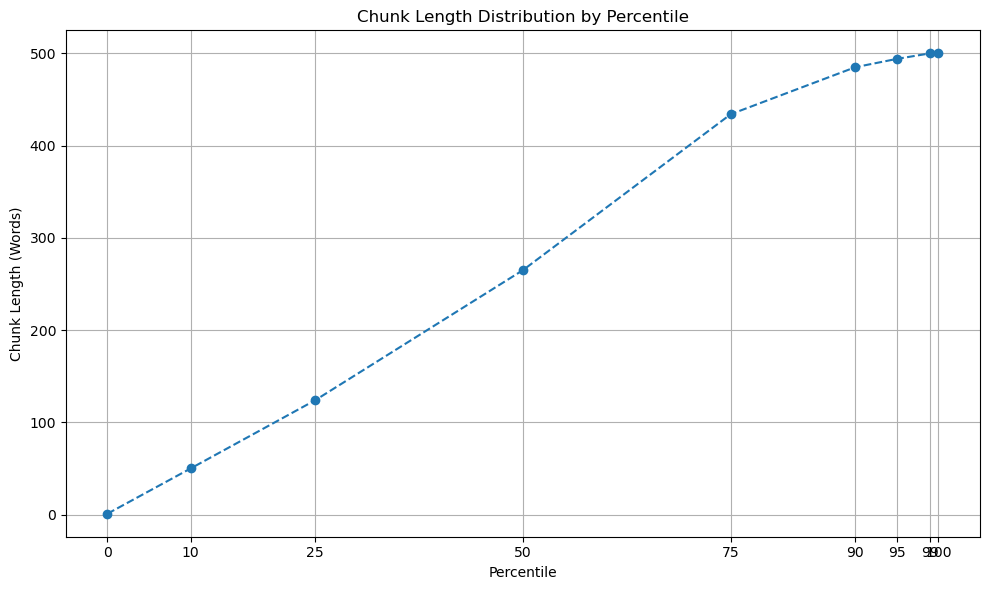

In [301]:
chunk_lengths = [len(chunk.split()) for chunk in sliding_chunks]
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
percentile_values = np.percentile(chunk_lengths, percentiles)

plt.figure(figsize=(10, 6))
plt.plot(percentiles, percentile_values, marker='o', linestyle='--')
plt.title('Chunk Length Distribution by Percentile')
plt.xlabel('Percentile')
plt.ylabel('Chunk Length (Words)')
plt.grid(True)
plt.xticks(percentiles)
plt.tight_layout()
plt.show()

Now it seems good

In [302]:
short_chunks = [chunk for chunk in sliding_chunks if len(chunk.split()) < 5]
print(f"Number of chunks shorter than 5 words: {len(short_chunks)}")


Number of chunks shorter than 5 words: 30


In [303]:
for i, chunk in enumerate(short_chunks[:20]):
    print(f"{i+1:02d}. ({len(chunk.split())} words): {chunk}")

01. (3 words): EU-China energy cooperation
02. (3 words): Long live Europe.
03. (4 words): Joint Assessment Framework dashboard
04. (3 words): 9 JULY 2025
05. (4 words): More information and application
06. (3 words): Download the publication
07. (3 words): Read the reporthere.
08. (4 words): Thank you very much.
09. (2 words): Market analysis
10. (3 words): See also here
11. (1 words): https://ec.europa.eu/eusurvey/runner/SUNSHINE_TrainingSeminars_ExpressionOfInterest
12. (1 words): Survey
13. (2 words): Give feedbackhere
14. (3 words): Share your feedback
15. (3 words): Questions & answers
16. (3 words): Market surveillance webpage
17. (3 words): Download the study
18. (3 words): DOWNLOAD THE STUDY
19. (4 words): PEFCR4Space project
EF Methods
20. (3 words): EU -Tajikistan partnership


In [304]:
len(sliding_chunks)

3852

In [305]:
filtered_chunks_3 = [
    chunk for chunk in sliding_chunks
    if len(chunk.split()) >= 5 or is_useful_short_chunk(chunk)
]

In [306]:
len(filtered_chunks_3)

3852

In [307]:
with open("filtered_chunks_v2_50_sliding.jsonl", "w", encoding="utf-8") as f:
    for chunk in filtered_chunks_3:
        json.dump({"chunk": chunk}, f)
        f.write("\n")

# In the next step try to vectorise this and then use using faiss cosine index then see if the performance has increased or not

In [310]:
chunk_embeddings_v2_sliding = model_2.encode(filtered_chunks_3, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

In [311]:
chunk_embeddings_v2_sliding.shape

torch.Size([3852, 768])

In [313]:
# torch.save(chunk_embeddings_v2_sliding, 'chunk_embeddings_v2_sliding.pt')
# chunk_embeddings_v2_sliding = torch.load('chunk_embeddings_v2_sliding.pt')

In [314]:
embeddings_v2_sliding = chunk_embeddings_v2_sliding.cpu().detach().numpy()
faiss.normalize_L2(embeddings_v2_sliding)
embedding_dim = embeddings_v2_sliding.shape[1]
index_2 = faiss.IndexFlatIP(embedding_dim)  # IP = inner product = cosine for normalized vectors
index_2.add(embeddings_v2_sliding)
faiss.write_index(index_2, "chunk_index_v2_cosine.faiss")

In [326]:
query = "List the ISINs of all the EU-Bills European commission auctioned on date 02/07/2025"
query_embedding = model_2.encode([query])
faiss.normalize_L2(query_embedding)

D, I = index_2.search(np.array(query_embedding).astype("float32"), k=20)

# Show top 5 retrieved chunks
for idx, score in zip(I[0], D[0]):
    print(f"\n🔹 Similarity: {score:.4f}")
    print(f"📄 Chunk: {filtered_chunks_3[idx]}")


🔹 Similarity: 0.7463
📄 Chunk: The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction. The results of this auction are as follows:
<table>
	EU-Bills	EU-Bills	EU-Bills
ISIN	EU000A4D85M6	EU000A3L7AT2	EU000A4EDCQ2
Date of auction	02/07/2025	02/07/2025	02/07/2025
Settlement date	04/07/2025	04/07/2025	04/07/2025
Maturity	03/10/2025	09/01/2026	03/07/2026
Volume bids *	1466	2594	4079
Volume allotment *	841	997	1398
Old outstanding amount *	2290	2399	0
New outstanding amount *	3131	3396	1398
Weighted average yield	1.922%	1.930%	1.920%
Highest accepted yield	1.935%	1.940%	1.935%
% awarded at highest accepted yield	100%	100%	51.85%
Cover ratio	1.74	2.60	2.92
</table>
* in millions of euros

🔹 Similarity: 0.7451
📄 Chunk: The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction. The results of this auction are as follows:
<table>
	EU-Bills	EU-Bills	EU-Bills
ISIN	EU000A4D7LA8	EU000A4EB329	EU000A4EB337
Date of au

## Word_count=300 , stride = 2 without similarity. Because I have seen in the above examples that even when the two adjacent sentances are not similar numerically they are related.

We can see that the retrieved chunks have repeting sentances. The problem with the repeting sentances is that they unnecessarily fill the context of the LLM. Other disadvantage of the repeating content is that is my ignore the later related retrievals and foucus on the repeated text more.

To deal with let's write a new frest chunking method which neatly chunks with less overlap the stride I used is 2 and the max wordcout I have used is 300. The max word count was set keeping in mind that reducing it might reduce the repeating content

In [327]:
metadata.head(5)

,title,url,date,text
0,Microfinance in Europe: Survey report 2024,https://social-economy-gateway.ec.europa.eu/mi...,2025-07-14,The European Microfinance Network (EMN) and th...
1,AccessibleEU surpassed all its objectives last...,https://accessible-eu-centre.ec.europa.eu/cont...,2025-07-14,AccessibleEU surpassed all its yearly objectiv...
2,EU invests 2.8 billion in 94 transport project...,https://urban-mobility-observatory.transport.e...,2025-07-11,"On the 3 July 2025, the European Commission an..."
3,Hamburg deploys AI to boost efficiency of elec...,https://urban-mobility-observatory.transport.e...,2025-07-11,"Hadag, the operator of Hamburg’s ferry service..."
4,Israel/Palestine: Statement by the High Repres...,https://north-africa-middle-east-gulf.ec.europ...,2025-07-11,Following the Israeli Cabinet’s resolutions an...


In [328]:
def sliding_sentence_chunking(text, max_words=300, stride=2):
    sentences = sent_tokenize(text)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    chunks = []
    i = 0
    n = len(sentences)

    while i < n:
        current_chunk = []
        word_count = 0
        j = i

        while j < n:
            sentence = sentences[j]
            sentence_word_len = len(sentence.split())
            
            if word_count + sentence_word_len > max_words:
                break

            current_chunk.append(sentence)
            word_count += sentence_word_len
            j += 1

        if current_chunk:
            chunks.append(" ".join(current_chunk))
        
        i += stride  # slide forward by stride (e.g., 2)

    return chunks


In [332]:
chunks = sliding_sentence_chunking(metadata.loc[largest_idx]['text'], max_words=300, stride=2)

In [333]:
chunks

["ent decisions, the European Commission takes legal action against Member States that fail to comply with their obligations under EU law. These decisions, covering various EU policy areas, aim to ensure the proper application of EU law for the benefit of citizens and businesses. The key decisions taken by the Commission are presented below and grouped by policy area. The Commission is also closing 112 cases where the issues with the Member States concerned have been solved. In these cases, the Commission does not have to pursue the infringement procedure further. The Commission's enforcement activities and Member States' compliance with EU law can be followed throughinteractive maps and customisable graphs. For more details on the history of a case or to access the full database of infringement decisions, theinfringement decisions' registeris open for consultation. And more information on the EU infringement procedure can be found in the followingQ&A. (For more information: Maciej Ber

In [335]:
chunk_2 = sliding_sentence_chunking(table_tagged_texts[44], max_words=300, stride=2)

In [336]:
chunk_2

['Today, the European Commission announced that it will, on behalf of the European Union, auction the following securities:\n<table>\n\tEU-Bonds04/07/20282.625%\tEU-Bonds04/07/20343.250%\tEU-Bonds05/10/20543.375%\nISIN\tEU000A4D5QM6\tEU000A3K4D41\tEU000A3K4EY2\nDate of auction\t14/07/2025\t14/07/2025\t14/07/2025\nSettlement date\t16/07/2025\t16/07/2025\t16/07/2025\nMaturity\t04/07/2028\t04/07/2034\t05/10/2054\nAnnounced volume *\tup to 2000\tup to 2000\tup to 1000\n</table>\n* in millions of euros\n\nMembers of the EU Primary Dealer Network are entitled to bid.Primary Dealers who wish to participate to the auction should be connected to TELSAT at 09:15\xa0a.m.\xa0CET on the date of the auction.Bidding closes at 11:30\xa0p.m.\xa0CET on the date of the auction.']

In [334]:
metadata.loc[largest_idx]['text']

"ent decisions, the European Commission takes legal action against Member States that fail to comply with their obligations under EU law. These decisions, covering various EU policy areas, aim to ensure the proper application of EU law for the benefit of citizens and businesses. The key decisions taken by the Commission are presented below and grouped by policy area. The Commission is also closing 112 cases where the issues with the Member States concerned have been solved. In these cases, the Commission does not have to pursue the infringement procedure further. The Commission's enforcement activities and Member States' compliance with EU law can be followed throughinteractive maps and customisable graphs. For more details on the history of a case or to access the full database of infringement decisions, theinfringement decisions' registeris open for consultation. And more information on the EU infringement procedure can be found in the followingQ&A. (For more information: Maciej Bere

In [337]:
all_chunks_3 = []
chunk_index_map_3 = {}


for idx, text in tqdm(metadata['text'].items()):
    chunks = sliding_sentence_chunking(text = text)
    start = len(all_chunks_3)
    all_chunks_3.extend(chunks)
    end = len(all_chunks_3)
    chunk_index_map_3[idx] = list(range(start, end))

317it [00:00, 834.81it/s]


In [339]:
len(all_chunks_3)

3173

In [340]:
with open("sliding_sentance_chunks_.pkl", "wb") as f:
    pickle.dump({"chunks": all_chunks_3, "index_map": chunk_index_map_3}, f)


In [341]:
min_idx = min(range(len(all_chunks_3)), key=lambda i: len(all_chunks_3[i].split()))
max_idx = max(range(len(all_chunks_3)), key=lambda i: len(all_chunks_3[i].split()))
shortest_chunk = all_chunks_3[min_idx]
longest_chunk = all_chunks_3[max_idx]
print(f"🔹 Shortest chunk (index {min_idx}, {len(shortest_chunk.split())} words):\n{shortest_chunk}\n")
print("="*80)
print(f"🔸 Longest chunk (index {max_idx}, {len(longest_chunk.split())} words):\n{longest_chunk}")



🔹 Shortest chunk (index 986, 1 words):
https://ec.europa.eu/eusurvey/runner/SUNSHINE_TrainingSeminars_ExpressionOfInterest

🔸 Longest chunk (index 43, 300 words):
Today, I want to pay tribute to the more than 8,300  Bosniak boys and men who were killed and those who are still missing. As some of the last victims of Srebrenica are buried in dignity, I also honour the mothers, wives, and daughters who continue to grieve, carrying the weight of loss through three decades. It is our duty to remember and to preserve the truth, so that future generations know exactly what happened. They must know that in the Summer of 1995, victims were systematically executed and buried in mass graves within the UN-designated 'safe area' of Srebrenica. A town they believed would protect them in the brutal war that was ravaging Bosnia and Herzegovina. The European Union will never forget what happened in this town. We acknowledge our past and recognise our responsibility for failing to prevent and stop the g

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

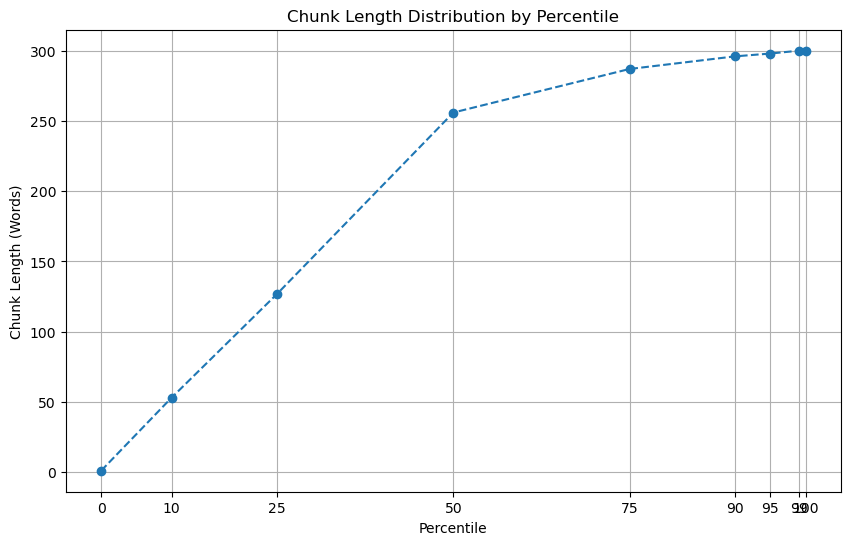

In [347]:
chunk_lengths = [len(chunk.split()) for chunk in all_chunks_3]

# Step 2: Define percentiles you want to see
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
percentile_values = np.percentile(chunk_lengths, percentiles)

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.plot(percentiles, percentile_values, marker='o', linestyle='--')
plt.title('Chunk Length Distribution by Percentile')
plt.xlabel('Percentile')
plt.ylabel('Chunk Length (Words)')
plt.grid(True)
plt.xticks(percentiles)
plt.tight_layout

In [348]:
short_chunks = [chunk for chunk in all_chunks_3 if len(chunk.split()) < 5]
print(f"Number of chunks shorter than 5 words: {len(short_chunks)}")

Number of chunks shorter than 5 words: 19


In [349]:
for i, chunk in enumerate(short_chunks[:20]):
    print(f"{i+1:02d}. ({len(chunk.split())} words): {chunk}")

01. (3 words): EU-China energy cooperation
02. (4 words): Joint Assessment Framework dashboard
03. (3 words): Download the publication
04. (3 words): Read the reporthere.
05. (2 words): Market analysis
06. (3 words): See also here
07. (1 words): https://ec.europa.eu/eusurvey/runner/SUNSHINE_TrainingSeminars_ExpressionOfInterest
08. (1 words): Survey
09. (3 words): DOWNLOAD THE STUDY
10. (3 words): Security Research Event
11. (3 words): Security Research Event
12. (3 words): Market surveillance webpage
13. (3 words): REGISTER HERE
AGENDA
14. (3 words): Market surveillance webpage
15. (4 words): What should I avoid?
16. (3 words): EU-Azerbaijan energy cooperation
17. (2 words): Event page
18. (4 words): More information is availablehere.
19. (2 words): Passenger Data


In [350]:
chunk_embedding_3 = model_2.encode(all_chunks_3, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/100 [00:00<?, ?it/s]

In [351]:
chunk_embedding_3.shape

torch.Size([3173, 768])

In [353]:

# torch.save(chunk_embedding_3, 'chunk_embeddings_3.pt')
chunk_embedding_3 = torch.load('chunk_embeddings_3.pt')


In [354]:
embeddings_3 = chunk_embedding_3.cpu().detach().numpy()
faiss.normalize_L2(embeddings_3)
embedding_dim = embeddings_3.shape[1]
index_3 = faiss.IndexFlatIP(embedding_dim)  # IP = inner product = cosine for normalized vectors
index_3.add(embeddings_3)
faiss.write_index(index_3, "chunk_index_3.faiss")

In [355]:
query = "List the ISINs of all the EU-Bills European commission auctioned on date 02/07/2025"
query_embedding = model_2.encode([query])
faiss.normalize_L2(query_embedding)

D, I = index_3.search(np.array(query_embedding).astype("float32"), k=20)

 # top 5 retrieved chunks
for idx, score in zip(I[0], D[0]):
    print(f"\n🔹 Similarity: {score:.4f}")
    print(f"📄 Chunk: {all_chunks_3[idx]}")


🔹 Similarity: 0.7463
📄 Chunk: The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction. The results of this auction are as follows:
<table>
	EU-Bills	EU-Bills	EU-Bills
ISIN	EU000A4D85M6	EU000A3L7AT2	EU000A4EDCQ2
Date of auction	02/07/2025	02/07/2025	02/07/2025
Settlement date	04/07/2025	04/07/2025	04/07/2025
Maturity	03/10/2025	09/01/2026	03/07/2026
Volume bids *	1466	2594	4079
Volume allotment *	841	997	1398
Old outstanding amount *	2290	2399	0
New outstanding amount *	3131	3396	1398
Weighted average yield	1.922%	1.930%	1.920%
Highest accepted yield	1.935%	1.940%	1.935%
% awarded at highest accepted yield	100%	100%	51.85%
Cover ratio	1.74	2.60	2.92
</table>
* in millions of euros

🔹 Similarity: 0.7451
📄 Chunk: The European Commission, on behalf of the European Union, has today carried out an EU-Bills auction. The results of this auction are as follows:
<table>
	EU-Bills	EU-Bills	EU-Bills
ISIN	EU000A4D7LA8	EU000A4EB329	EU000A4EB337
Date of au

In [356]:
query = "When is the deadline for submitting applications to join the Platform on Sustainable Finance?"
query_embedding = model_2.encode([query])
faiss.normalize_L2(query_embedding)

D, I = index_3.search(np.array(query_embedding).astype("float32"), k=20)

#  top 5 retrieved chunks
for idx, score in zip(I[0], D[0]):
    print(f"\n🔹 Similarity: {score:.4f}")
    print(f"📄 Chunk: {all_chunks_3[idx]}")


🔹 Similarity: 0.7271
📄 Chunk: The call for applications for the Platform on Sustainable Finance will beopen until 7 September 2025. More information and application

🔹 Similarity: 0.6597
📄 Chunk: The Commission will directly appoint the seven permanent members, representing public entities. In addition, individuals, organisations and public entities other than Member States’ authorities may be granted observer status by the Commission. The call for applications for the Platform on Sustainable Finance will beopen until 7 September 2025. More information and application

🔹 Similarity: 0.6148
📄 Chunk: The new platform will be composed of up to 35 members, of which up to 28 will be selected through today's call for applications. The Commission will seek to achieve a balanced selection, including individuals appointed in a personal capacity with proven experience, as well as those representing stakeholder interests, civil society, organisations academia and research institutes. The Commiss

Its still repeating the stuff but let's see what happens when we generate the answers in the other notebook

## Let's try one last thing, use langchain chunking for very simple chunking with chunk len of 500 characters and 250 chars overlap.

In [49]:
pip install langchain openai tiktoken


   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 1.1 MB/s eta 0:00:01
   ------------------------------- -------- 0.8/1.0 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/894.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/894.9 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/894.9 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/894.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 894.9/894.9 kB 1.1 MB/s eta 0:00:00

   ------------- -------------------------- 2/6 [langsmith]
   ------------- -------------------------- 2/6 [langsmith]
   ------------- -------------------------- 2/6 [langsmith]
   -----

In [51]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [65]:
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain.embeddings import HuggingFaceEmbeddings

In [52]:
document_text = """The European Microfinance Network (EMN) and the Microfinance Centre (MFC) announced a collaborative initiative in April 2024..."""

# Initialize splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,         
    chunk_overlap=200,       
)

chunks = text_splitter.split_text(document_text)

# Print chunks
for i, chunk in enumerate(chunks):
    print(f"\n🔹 Chunk {i+1}:\n{chunk}")


🔹 Chunk 1:
The European Microfinance Network (EMN) and the Microfinance Centre (MFC) announced a collaborative initiative in April 2024...


In [53]:
def chunk_article(text):
    if pd.isna(text):
        return []  # Handle NaNs
    return text_splitter.split_text(text)
chunks = metadata["text"].apply(chunk_article)

In [54]:
len(chunks)

317

In [55]:
chunks[0]

['The European Microfinance Network (EMN) and the Microfinance Centre (MFC) are pleased to present the12th editionof their flagship publication:Microfinance in Europe: Survey Report. This long-standing survey remains the leading source of data and analysis on the microfinance sector in Europe.',
 'For thesixth consecutive survey edition, EMN and MFC have joined forces to capture data from the vast majority of European microfinance institutions, providing the most comprehensivedatasetavailable on the sector today.',
 'This edition focuses on thetypes of businesses reached by microfinanceand highlights thesocial performance of business loans, along with theimpact measurement approachesadopted by MFIs. It offers valuable insights into how these institutions contribute to social inclusion, entrepreneurship, and local development.',
 'The report serves as an importantpolicy tool, supportingevidence-based decision-making for policymakersworking to strengthen financial inclusion and the socia

In [56]:
all_chunks_flat = [chunk for article_chunks in chunks for chunk in article_chunks]

In [61]:
with open("all_chunks_flat.pkl", "wb") as f:
    pickle.dump({"chunks": all_chunks_flat}, f)


In [57]:
min_idx = min(range(len(all_chunks_flat)), key=lambda i: len(all_chunks_flat[i].split()))
max_idx = max(range(len(all_chunks_flat)), key=lambda i: len(all_chunks_flat[i].split()))

# Retrieve the shortest and longest chunks
shortest_chunk = all_chunks_flat[min_idx]
longest_chunk = all_chunks_flat[max_idx]

# Print results
print(f"🔹 Shortest chunk (index {min_idx}, {len(shortest_chunk.split())} words):\n{shortest_chunk}\n")
print("="*80)
print(f"🔸 Longest chunk (index {max_idx}, {len(longest_chunk.split())} words):\n{longest_chunk}")

🔹 Shortest chunk (index 381, 1 words):
Overview

🔸 Longest chunk (index 145, 91 words):
To my second point. Since the full-scale invasion, Europe has been and is Ukraine's largest donor – with almost EUR 165 billion of support. This year alone we will cover 84 % of external financing needed. As part of this support, I can announce EUR 1 billion payment in macro financial support as well as a payment of more than EUR 3 billion from the Ukraine Facility. The guarantees and grants that we are signing at this Conference are set to unlock up to EUR 10 billion in investments for growth,


In [58]:
chunk_embeddings_langchain = model_2.encode(all_chunks_flat, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

In [59]:
embeddings_4 = chunk_embeddings_langchain.cpu().detach().numpy()
faiss.normalize_L2(embeddings_4)
embedding_dim = embeddings_4.shape[1]
index_4 = faiss.IndexFlatIP(embedding_dim) 
index_4.add(embeddings_4)
faiss.write_index(index_4, "chunk_index_langchain.faiss")

In [66]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


C:\Users\shri\AppData\Local\Temp\ipykernel_5020\540329756.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


In [67]:

documents = [Document(page_content=chunk) for chunk in all_chunks_flat]
vectorstore = FAISS.from_documents(documents, embedding_model)
vectorstore.save_local("chunk_index_langchain_2")